# Resources & Acknowledgements

While planning this book, I often found myself wondering what my Linear Algebra and ODE professor, Lin Bon-Soon, would have said in his lectures. My goal was to emulate how other works achieve a tone of profound rigor in their acknowledgements—often through opening with a saying from a great physicist (or mathematician)—so this work could supposedly stand alongside other well-crafted ML/AI resources. Professor Lin and I both know that Evan rarely attended class, which makes this entire endeavor somewhat ironic.

Fret not, I made the effort to look through my old emails and found this gem from him:
>"If you do decide to pick something that matters to you, then focus on mastery, instead of achievement. Mastery is current, future-proof, and demonstrable; achievement is past-tense and soon irrelevant. (I refer to personal achievement—not, for instance, an achievement that saved the world.) I'm not saying achievement isn't great; mastery is simply better."

Somewhat it resonates greatly with what I am trying to achieve. Instead of just building a simple ML/AI project by using a pretrained model from YouTube and then calling it a day, I want to actually master the basics of ML/AI through a Herculean task—by building a super-duper complex ML model from scratch to be able to tell if that image you took was of a cat, a dog, or neither (a problem worth challenging!).

Anyways you innocent reader, if you have made this far, then I will reveal what are used in this project. This project is built as a learning exercise and the following explanation, analysis and theoretical foundations are based upon these incredible resources:
- **[D2L.ai (Dive into Deep Learning)](https://d2l.ai/)**
- **Pattern Recognition and Machine Learning (2006)** by Christopher M. Bishop.
- **Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow** by Aurélien Géron.
- **Deep Learning Research Papers:**
  - He, K., Zhang, X., Ren, S., & Sun, J. (2015). [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)  
  - LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). [Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)  
- **AWS Documentation** for ECS, SageMaker, CodeDeploy, and CodePipeline.

They are-what my generation coined-the goat of resources.

# 1.0 The Building Blocks
This notebook will attempt to build all of the required crucial units that are the foundation to the CNN (Convolutional Neural Network) layer, then, we will use the CNN layer to put together the ResNet (Residual Network) model, a very power and efficient model for computer imaging task.

We will attempt to build such a model that, given a picture, is able to predict if it's a cat, a dog, or neither.

## 1.1 What is a model?
At its simplest essence, a model is just a function. It's a box with a bunch of knobs and dials on it. You feed it an input—a number, a list of numbers, a 2D grid of numbers (like a black-and-white photo), or even a 3D block of numbers (like a color photo with Red, Green, and Blue layers). You twist the knobs, and it gives you an output.

Okay, let's not stray from the topic. A model accepts an input and it outputs something. That something could be a true/false value, a scalar, a vector... you get the idea.

Now, we want to use our model to accept an image of a cat (which is that 3D matrix) and have it output a decision. Something like this:

$$(1, 0, 0)$$

This output is a vector where the number $1$ indicates "true" and $0$ indicates "false." Each item in the vector corresponds to a **label**: $[Cat, Dog, Neither]$.

So in this case, the vector $(1, 0, 0)$ translates to: Cat: True, Dog: False, Neither: False. Our model is very confident that its **label** is probably a cat

Oh yeah, I'm going to **bold** terminology **you** may **not** understand. In a classification problem, you want to predict the names, or the commonly used term, **label** of an image.

Now a model by itself is pretty dumb, think Evan facing his first Linear Algebra exam with no sleep and studies. It must be able to "learn" somehow. Now, you may ask:

"That's pretty stupid, how could a model **learn**?"

Models have **weights**. Weights are tunable parameter within the model that influence the outcome. Think of them as the knobs on a complicated soundboard you adjust through trial and error to get the perfect sound.

These weights can be adjusted through trials and errors through a certain process, we call that "**learning**".

We will dive into the Stochastic Gradient Descent algorithm, which forces a model to learn (they must! they have no choice). The analogy is comparable to Evan and his Linear Algebra exams: Evan got a bad score on his first exam, and so, taking the partial derivative of the loss function with respect to the weight (to be explained), multiplying that with the learning rate, then adding it back to the weight, Evan will successfully perform better the next exam. Surprisingly, Evan did for the second exam.

Now we have an idea of what a model does and how it can learn. We will dive further into making of one of the oldest and elementary model, Linear Regression, then we will move on to a much more predictive model called Softmax Regression, which is suitable for classification, next, we move to stacking the model together, a Multilayer Perceptron, and finally learn the tricks to help our model learn and converge efficiently and quickly. Also take notes of how many times the word "efficiently" and "simplest" are used in our notebook.

## 1.2 Linear Regression
This is one of the most basic ML model. In the context of Machine Learning, Linear Regression is a model that predicts a continuous value based on the **features** of our data, underlined by the premise that there is a linear relationship.

a **feature** is just one characteristics of a data. Ex: In predicting the house's price, features like location, land size, age, etc are used to train/learn a model.

So, How does Linear Regression look like mathematically?

We define $\hat{y}$ to be the **prediction**, the output of the model, $(x_1, x_2, ..., x_n)$ to be the **input** with $x_i$ being our features and $(w_1, w_2, ..., w_n)$ to be our *weights*.

Thus, the Linear Regression formula that ingest a single datapoint is:  

$$\hat{y} = x_1 w_1 + x_2 w_2 + ... + x_n w_n$$
$$\hat{y} = (x_1, x_2, ..., x_n)^T(w_1, w_2, ..., w_n)$$

Let $\mathbf{x}^T$ be our dataset and $\mathbf{w}$ be our weights. We can write this compactly with in the manner of Linear Algebra (thanks Lin! don't forget to thank Lin dear readers)
$$\hat{y} = \mathbf{x}^T \mathbf{w}$$

wait! but there's a problem. If all of our inputs $(x_1, x_2, ..., x_n)$ are really small or near zero, then wouldn't our **prediction** be also be near 0 for some case? To avoid that, Bishop showed that by adding a **bias** $b$, we can have to have a "fixed offset" [[1, 138]](#ref1) yielding a complete formula.

$$\hat{y} = \mathbf{x}^T \mathbf{w} + b$$

let us now convert this into a PyTorch module for future uses.

In [84]:
import torch
from torch import nn
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from d2l import torch as d2l

We will attempt to replicate `nn.Linear` from scratch. First we will define the weight, bias, and the forward method, which is called to predict our $\hat{y}$

In [120]:
class LinearRegression(d2l.Module):
    def __init__(self, in_features, out_features, lr=0.01, bias=True):
        super().__init__()
        # weight, add requires_grad=True to perform manual weight changes
        self.w = nn.Parameter(torch.normal(0, 0.01, (in_features, out_features)))
        # bias
        self.b = nn.Parameter(torch.zeros(out_features) if bias else None)
        # will be covered later
        self.lr = lr
        self.bias = bias

    def forward(self, X):
        return torch.matmul(X, self.w) + self.b

With this model in the palm of our fellow reader, we are ready to do more. It's time we need to make this static cluster of symbols somehow **learn**, but before that we need to understand how it learns.

### 1.2.1 Loss
The model must learn toward finding the **weights** that will predict **label** with the least error, or in other words, with **minimal loss**. **Loss** trivially tells you how far you are from the **target** label, which is ground truth, or the actual value in reality.

But how is loss relevant to the process of learning?

The process of learning is iterative and for each iteration, our model, through SGD (explained in detail in later section), will pick a batch of inputs from the datasets $X_k = (\mathbf{x_i}, \mathbf{x_{i+1}}, ..., \mathbf{x_{i+n}})$, where $n$ is the size of the batch, to output predictions $\hat{Y_k} = (\mathbf{\hat{y}_i}, \mathbf{\hat{y}_{i + 1}}, ..., \mathbf{\hat{y}_{i + n}})$. We then calculate the loss by comparing the predictions to the **target** labels $Y_k = (\mathbf{y_i}, \mathbf{y_{i+1}}, ..., \mathbf{y_{i+n}})$, which gives us the current performance of a model in predicting to unseen values. We seek to minimize the loss on every step so that we know the model is becoming more and more accurate.

The most commonly used loss function is the **Mean Squared Error**, which we will use for Linear Regression. It is defined by
$$l(y,\hat{y}) = \frac{1}{n} \sum_{i=1}^{n}(y_i - \hat{y_i})^2$$
So for each iteration, **MSE** will serve as a useful bench mark. Let's create an MSE function. Then, we attach it to the `LinearRegression` module above

In [127]:
def MSE(self, y_hat, y):
    n = y.numel()
    return torch.sum((y - y_hat) ** 2) / n
LinearRegression.loss = MSE

### 1.2.2 Stochastic Gradient Descent
This is the eureka part of anyone learning ML/AI for the first time. What **Stochastic Gradient Descent** does simply is that it takes the **gradient** or the partial derivative of the loss function in respect to the weight and bias. The **gradient** represents the direction where our function is the **steepest** and so if we make our loss function head in the opposite of the gradient, we are sure to reduce the loss. However, we must augment the negative gradient with a **learning rate** so that we do not overshoot when we attempt to minimize the loss.

If this is confusing to you then imagine yourself in a valley full of mountains where you're given a compass that always point to the direction of the steepest hill (the **gradient**). Your goal is to end up to a lower altitude and to do so, you would just take few and small steps opposite to the gradient thousands of time. By doing this, you ensure that you will never end up on the valley's peak (**high loss**) and you may somehow, by luck, stumble into the plains thereby guaranteeing your safety from the fangs of mountain lion (beware though, they may appear in local minina that leads to nowhere).

So in every batch $k$ and learning rate $\eta$, SGD improves the weight by the formula below.
$$\mathbf{w} \leftarrow \mathbf{w} - \eta\frac{{\partial l(y,\hat{y})}}{{\partial \mathbf{w}}}$$
$$b \leftarrow b - \eta\frac{{\partial l(y,\hat{y})}}{{\partial b}}$$

### 1.2.3 Putting it together
What is left now is putting together a fully working basic ML model. We have our `forward` method that performs the Linear Regression operation on our input to give us our output, we have the `loss` method that calculate our errors per iteration to serve as our benchmark. Finally, we will need to implement the SGD for our model.

We will need to implement the SGD using the blueprint of the `torch.optim.Optimizer` class and then attach it to our Linear Regression's `configure_optimizers`


In [126]:
class SGDFromScratch(torch.optim.Optimizer):
    def __init__(self, params, lr=0.01):
        defaults = dict(lr=lr)
        super().__init__(params, defaults)
        self.lr = lr 
    
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        
        for group in self.param_groups:
            for param in group['params']:
                if param.grad is not None:
                    param.data.add_(-self.lr, param.grad.data)
        
        return loss

    def zero_grad(self):
        for group in self.param_groups:
            for param in group['params']:
                if param.grad is not None:
                    param.grad.zero_()

In [125]:
def configure_optimizers(self):
    return SGDFromScratch(self.parameters(), self.lr)
LinearRegression.configure_optimizers = configure_optimizers

voila, we have a working Linear Regression Model. Let's see if it works.

Say for whatever reason, we want to predict Evan's performance on his Linear Algebra's exams. We have a dataset of two hundred datapoints of his past performance. Let $\mathbf{X}_{Evan}$ be a synthetic dataset where each dataset's point has the following structure:
$$
\begin{bmatrix}
\text{hours of sleep per day,} &
\text{hours of study per day,} &
\text{exam score}
\end{bmatrix}
$$

when we train on the dataset, we want the model to be able to learn the linear relationship between $[\text{hours of sleep per day}, \text{hours of study per day}]$, which are our features, and $\text{exam score}$, our target label.

We want to bake in some scenario for the dataset. Say if Evan sleeps and studies a lot, then he is sure to achieve a score of 85+ every time. We will synthetically generate 80 datapoints that incorporate this scenario drawing from a normal distribution.

In [469]:
sleep_hours = torch.normal(mean=8.0, std=1.5, size=(80,1))
study_hours = torch.normal(mean=8.0, std=2.0, size=(80,1))
exam_scores = torch.normal(mean=85.0, std=1.0, size=(80,1))

dataset = torch.cat([sleep_hours, study_hours, exam_scores], dim=1)
dataset[:5]

tensor([[ 9.0017,  7.1795, 84.6106],
        [ 6.6685,  6.1595, 84.5599],
        [ 6.8990,  6.7839, 85.7934],
        [ 6.7618,  8.3001, 86.0304],
        [ 8.3701,  9.9533, 86.4373]])

Now let's bake in four more scenarios:
1. if Evan sleeps a lot, but doesn't study. The result? He will perform badly
2. if Evan doesn't sleep, but studies. The result? He will also perform badly
3. if Evan sleep and study mediocrely (if that is a word), he will perform mediocrely
4. if Evan doesn't sleep and doesn't study (unrealistic). He. will perfomy SUPER DUPER BADLY

In [470]:
scenario_1 = torch.cat([torch.normal(mean=12.0, std=1.5, size=(30,1)),
                        torch.normal(mean=2.0, std=2.0, size=(30,1)),
                        torch.normal(mean=60, std=1.0, size=(30,1))], dim=1)

scenario_2 = torch.cat([torch.normal(mean=2.0, std=1.5, size=(30,1)),
                        torch.normal(mean=12.0, std=2.0, size=(30,1)),
                        torch.normal(mean=70, std=1.0, size=(30,1))], dim=1)

scenario_3 = torch.cat([torch.normal(mean=6.0, std=1.5, size=(30,1)),
                        torch.normal(mean=6.0, std=2.0, size=(30,1)),
                        torch.normal(mean=75, std=1.0, size=(30,1))], dim=1)

scenario_4 = torch.cat([torch.normal(mean=2.0, std=1.5, size=(30,1)),
                        torch.normal(mean=2.0, std=2.0, size=(30,1)),
                        torch.normal(mean=45, std=1.0, size=(30,1))], dim=1)
dataset = torch.cat([dataset,
                     scenario_1,
                     scenario_2,
                     scenario_3,
                     scenario_4], dim=0)

dataset[torch.randint(0, 100, (5, 1))], dataset.shape

(tensor([[[ 8.7968,  8.1036, 83.7333]],
 
         [[10.9613, 10.4859, 83.9850]],
 
         [[ 8.2971,  6.4249, 85.8359]],
 
         [[ 6.5184,  9.3531, 84.9446]],
 
         [[ 6.8971,  7.7547, 84.4932]]]),
 torch.Size([200, 3]))

For easier visualization, I will convert this into a pandas dataframe (not just flexing my newly acquired Pandas skill smh)

In [386]:
ndarray = dataset.numpy()
df = pd.DataFrame(ndarray, columns=("sleep hours", "study hours", "exam scores"))
df

,sleep hours,study hours,exam scores
0,8.444556,9.201805,85.000000
1,8.803197,5.459167,85.513573
2,9.852214,5.561637,85.000000
3,10.536791,7.558424,92.660812
4,6.333850,7.537483,85.000000
...,...,...,...
195,0.739375,1.473207,44.395798
196,2.353088,5.339028,46.093761
197,0.812066,0.518813,44.406734
198,2.335888,0.457154,44.697990


With the dataset constructed, we will use d2l's `DataModule` to consume the data. Although not explicit, the `DataModule` will shuffle the dataset to ensure randomness, which is crucial to learning, and then will take a batch of data points every iteration to train the model

In [462]:
class ExamDataModule(d2l.DataModule):
    def __init__(self, dataset, batch_size=8):
        super().__init__()
        self.X = dataset[:, :2]
        self.y = dataset[:, 2:]
        self.batch_size = batch_size

    def get_dataloader(self, train: bool):
        return d2l.load_array((self.X, self.y), batch_size=self.batch_size, is_train=train)


Finally, we will create an instance for all the objects we have created above and train the module. We will configure the trainer to **5 epochs**, meaning 5 complete passes over the data, a **batch size of 32**, and a **learning rate of 0.01**. 

Any small of a value for the learning rate will lead to you being chased by a group of mountain lions (meaning you won't converge) that doesn't want you to see the secretive underlying linear relationship. While too large of a value cause the overshooting of optimal minima, this can lead to **weight explosion**, which causes numerical overflow and thus `NaN` results for your model.

Regularizer, also known as "weight decay", are essential in tackling this problem due to their tendency to tell the weight to stick close to 0 to maintain numerical stability [[1, 144]](#ref1). Now **L2 regularization** would be used in this case, but for the sake of brevity, I would leave the reader to discover this concept at your own peril. We will talk about other techniques to mitigate the issue brought above. 

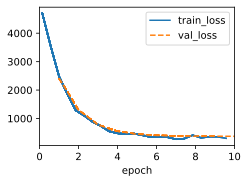

In [497]:
model = LinearRegression(in_features=2, out_features=1, lr=0.0003)
dataloader = ExamDataModule(dataset, batch_size=32)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, dataloader)

Let's see what it says when I slept for 4 hours but studied for a total of 8 hours.

In [498]:
model(torch.tensor([4.0, 8.0]))

tensor([61.2259], grad_fn=<AddBackward0>)

That's pretty much what I got on the exam. Well done! wait, so what If I sleep an extra 1.5 hours?

In [499]:
model(torch.tensor([5.5, 8.0]))

tensor([68.3270], grad_fn=<AddBackward0>)

Oh look, an instant grade improvement???!!! Evan needs to sleep more.

One thing to note though, we haven't touched upon a few many things and I leave it up to the interested reader to find out themselves:
- How the learning rate is chosen?
- How the batch size is chosen?
- How is the model's weight and bias initialized and why it may affect the convergence of the model's training?
- What happens if I input negative data? Or use data that are out-of-bound?
These decision, though subtle, are crucial to the learning of a model.

## 1.3 Softmax Regression
Professor Lin once offered the class his boundless wisdom, claiming there are only four (or possibly five, I don't take notes in his class) possible grades: A for Excellence, B for "good enough but try harder", C for "try harder", and anything lower constituting Failure.

Funnily, he sounds like a typical Softmax Regression model. Instead of predicting a continuous score that quantifies a student's performance, this approach bins them into discrete categories: A, B, C, or Failure.

Where Linear Regression answers "how much?", Softmax Regression answers "which one?".

Let's look at the structure of a Softmax Regression Model.

### 1.3.1 Model Structure
We first need to understand the input and output of a classification problem.  A classification problem accepts high-dimensional data like image or audio. We define $\mathbf{x}$ to be a vector made of all image's pixel values flattened. For simplicity, we assume a grayscale image rather than one with color, where each pixel $x_i$ represents a brightness value. The total length $m$ of this vector is $n = w \times h$, with w and h being the width and height, respectively.

Now instead of predicting a single label, we will have fixed numbers of distinct label we want to predict. Let the set of label be $C$ and the number of distinct label be $k$. To exemplify this, the `FashionMNIST` dataset has a total of 10 type of clothing. 

Understanding that now that there are multiple outputs, Softmax Regression can be thought of as *multiple Linear Regression* in a trench coat. We define the logit vector ${\mathbf{a}}$ representing the intermediate result of our model.

Observe,
$$
\begin{equation}
\left\{
\begin{aligned}
a_1 &= x_1w_{1,1} + x_2w_{1,2} + ... + x_nw_{1,n} + b_1 \\
a_2 &= x_2w_{2,1} + x_2w_{2,2} + ... + x_nw_{2,n} + b_2 \\
&\vdots& \\
a_m &= x_1w_{k,1} + x_2w_{k,2} + ... + x_nw_{m,n} + b_k \\
\end{aligned}
\right.
\end{equation}
$$

We let $\mathbf{W}$ be a matrix of $k \times n$ and the bias be a column vector $\mathbf{b}$

$$
\mathbf{a} = \mathbf{W}\mathbf{x}^T + \mathbf{b}
$$

The vector $\mathbf{a}$ contains logit values $(a_1, a_2, ..., a_k)$ that corresponds to the raw score for each label $C_i$. Our intuition may be to pick the largest logit value, but our model can interpret these scores as **probabilistic distribution** [[1, 197]](#ref1). A conversion to probabilities is warranted, it helps us to see quantify the mode's confidence (useful for loss functions) with its prediction, rather than relying on arbitrary raw scores.

### 1.3.2 Softmax function
In order to transform the model structure above to a probabilistic model adhering to the dataset's distribution. We would use some statistics, according to Bishop [[1, 197]](#ref1):

$$
\begin{align*}
  p(C_i|\mathbf{x}) &= \frac{ p(\mathbf{x}|C_i)p(C_i) }{ \sum_{j} p(\mathbf{x}|C_j)p(C_j) } && 
  \text{(Bayes Theorem, you know this!)} \\
  &= \frac{exp(a_i)}{\sum_{j} exp(a_j) } \\
  &= softmax(o_i)
\end{align*}
$$

Which is basically saying "Hey, from all the occurrences of $\mathbf{x}$, what are the possibility of seeing $C_k$?". With Bayes Theorem, you can relate the logit values to each label's probability

$$
y_i = softmax(o_i)
$$

$$
\mathbf{y} = softmax(\mathbf{o})
$$

Thus, our output, for each index, represents how confidence the model is that the input or image is of that $label$. Thereby, the output will look something like this:

$$
(0.01, 0.02, 0.04, 0.80, 0.3, 0.0, 0.0, 0.05, 0.05, 0.0)
$$

In this example, the 4th element is the highest probability (0.8, or 80%), indicating that our model is most confidence that our input is of label $C_4$. This probabilistic representation not only intuitive, but also it sums up nicely to $1$ for all output. 

Although there are other non-zero probabilities, our model must decide and pick label as its prediction. Thus, we will convert this into a **one-hot encoding** where the label with the highest probability will be picked.

$$
(0, 0, 0, 1, 0, 0, 0, 0, 0, 0)
$$

Atlas, we have classified an input. Lin will surely give me an A for this (or a star, or a sticker). Let's work on the implementation of Softmax.

In implementing Softmax, the naive implementation that follows the mathematical definition will result in numerical overflow and underflow [[D2l, Sec. 4.5.2]](#ref2). To solve this, we will take the max $o_i$, subtract it from all the elements first to get a new logit vector, then we would actually transform the vector using Softmax.

In [77]:
def softmax(o):
    o_max = o.max(dim=1, keepdim=True).values
    transformed_logits = o - o_max
    return torch.exp(transformed_logits) / torch.exp(transformed_logits).sum(dim=1, keepdim=True)


Now we create a module for Softmax Regression. We will use the **SGD** algorithm above to update the model's **weights**.

In [78]:
class SoftmaxRegression(d2l.Classifier):
    def __init__(self, in_features, out_features, lr=0.01, bias=True):
        super().__init__()
        self.lr = lr
        self.bias = bias
        self.net = LinearRegression(in_features, out_features, lr, bias)
    def forward(self, X):
        X = X.reshape((-1, self.net.w.shape[0]))
        return softmax(torch.matmul(X, self.net.w) + self.net.b)
SoftmaxRegression.configure_optimizers = configure_optimizers


### 1.3.3 Cross-entropy Error function
For good reasons I won't explain, we will not be using MSE for this sort of problem. This is because MSE deals with linear scalar value, I don't think it's a good idea to derive the loss from the differences of probabilities. 

Bishop, my least favorite chess piece, introduces Cross-entropy Error function [[1, 209]](#ref1). Consider a likelihood function for our given dataset where there $n$ samples, $k$ distinct labels. The likelihood represents the probability of observing all the true labels given the dataset. Let $\mathbf{Y}$ a matrix containing all the hot-encoded **target labels**, and $\mathbf{X}$ be a matrix of all features.

$$
p(\mathbf{Y} | \mathbf{X}) = \prod_{i=1}^{n} \prod_{k=1}^{m} P(C_k|\mathbf{x}_i)^{y_{i,k}}
$$

What matters is the ground truth. In a **one-hot encoded vector**, $y_{i,k}$ is 1 if that's the target label, and 0 if it's not. Let $C_j$ be the true label.

$$
p(\mathbf{Y} | \mathbf{X}) = \prod_{i=1}^{n} P(C_j|\mathbf{x}_i)
$$

Professor Lin says that Laplace Transform are cool, so are logarithms (negative ones!). Below is why

$$
-\ln{p(\mathbf{Y} | \mathbf{X})} = -\sum_{i=1}^{n} \ln{P(C_j|\mathbf{x}_i)}
$$

$P(C_j|\mathbf{x}_i)$ is akin to the model's confidence $\hat{y}_i$ of the label $C_j$ with respect to input $\mathbf{x}_i$.

$$
-\ln{p(\mathbf{Y} | \mathbf{X})} = -\sum_{i=1}^{n} \ln{\hat{y}_i}
$$

The reason we took the negative likelihood is that in the framework of ML/AI, we always aim to minimize the loss. The likelihood represents how likely it is for a prediction to turn out to be true, the negative likelihood is the loss function which we seek to minimize. Let $\hat{\mathbf{Y}}$ be the matrix of all predictions

$$
l(\mathbf{Y}, \hat{\mathbf{Y}}) = -\sum_{i=1}^{n} \ln{\hat{y}_i}
$$

Think about it. If our model shows too low of a value of $\hat{y}_i$ then our loss would be substantial since it's a negative logarithm. This represents a huge cost! With Cross-entropy error, the model attempts to increase the likelihood of the label $C_j$ occurring and zero out other labels. Just check demos on what a negative logarithm function looks like.

Phew, let's implement it

In [79]:
def CrossEntropyError(self, y_hat, y):
    row_indices = torch.arange(y.shape[0])
    return -torch.log(y_hat[row_indices, y]).mean()

SoftmaxRegression.loss = CrossEntropyError

We are now ready to test our new classification model. Let us use the `FashionMNIST`, and for convenience, we will use D2L's `FashionMNIST`, which contains a `visualize` method for us to see what the data looks like.

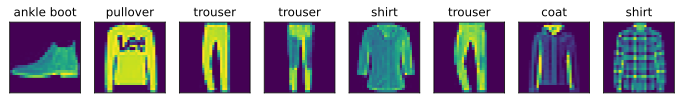

In [80]:
data = d2l.FashionMNIST(batch_size=256)
batch = next(iter(data.val_dataloader()))
data.visualize(batch=batch)

We will take a batch like these on every training step, and then adjust the weight, again like Linear Regression, through SGD. The SGD draws the loss from `CrossEntropyError` this time rather than `MSE`. Now let us train our model.

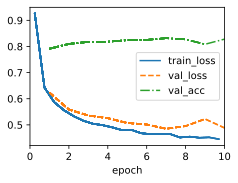

In [81]:
# 28 * 28 = 784
model = SoftmaxRegression(in_features=784, out_features=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

Our model seems pretty accurate. Let's take a single batch from the data and test it on the model.

In [82]:
X, y = next(iter(data.get_dataloader(train=False)))

X = X.reshape((-1, 784))
with torch.no_grad():
    y_hat = model(X)
    preds = y_hat.argmax(dim=1)
    
acc = (preds == y).float().mean().item()
print(f"Batch accuracy: {acc:.2%}")

Batch accuracy: 86.72%


## 1.4 Conclusion
We have built the foundation and intuitive for putting together an ML/AI model. Many important topics that underlines the performance of a model, both in training and prediction, have not been touched, and I really recommend the reader (assuming you no nothing about ML/AI) to read up on it in D2L or in Bishop's Pattern Recognition and Machine Learning book. Apart from these two, there are troves of good resources throughout the internet to strengthen your intuition on why many of the things in this book simply works. We have simply scratched the surface of Machine Learning

## References

<a name="ref1">[1]</a> C. M. Bishop, *Pattern Recognition and Machine Learning*. New York, NY, USA: Springer, 2006. [Online]. Available: https://www.springer.com/gp/book/9780387310732

<a name="ref2">[2]</a> A. Zhang, Z. C. Lipton, M. Li, and A. J. Smola, *Dive into Deep Learning*. 2021. [Online]. Available: https://d2l.ai